This code is adapted from Tasha Snow's ERA5 downloading script: https://github.com/tsnow03/Landsat_SST_algorithm/blob/main/ERADownload.ipynb

In [3]:
%pip install ecmwf-api-client
%pip install cdsapi

  Using cached ecmwf_api_client-1.6.5-py3-none-any.whl.metadata (4.8 kB)
Using cached ecmwf_api_client-1.6.5-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached cdsapi-0.7.5-py2.py3-none-any.whl.metadata (2.9 kB)
  Using cached datapi-0.3.1-py3-none-any.whl.metadata (20 kB)
  Using cached multiurl-0.3.5-py3-none-any.whl.metadata (2.8 kB)
Using cached cdsapi-0.7.5-py2.py3-none-any.whl (12 kB)
Using cached datapi-0.3.1-py3-none-any.whl (28 kB)
Using cached multiurl-0.3.5-py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import calendar
from ecmwfapi import ECMWFDataServer # Need a ecmwf user name and password first
import cdsapi

The CDS API can be a bit picky with inputs from ERA5, so first-time users are encouraged to use the online request form (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download) to automatically generate a code for their API request, to ensure that the syntax is correct.

In [ ]:
c = cdsapi.Client()

def retrieve_era5():
    """      
       A function to demonstrate how to iterate efficiently over several years and months etc    
       for a particular interim_request.     
       Change the variables below to adapt the iteration to your needs.
       You can use the variable 'target' to organise the requested data in files as you wish.
       In the example below the data are organised in files per month. (eg "interim_daily_201510.grb")
    """
    yearStart = 2020
    yearEnd = 2020
    monthStart = 3
    monthEnd = 4
    dayStart = 1
    dayEnd = 30
    for year in list(range(yearStart, yearEnd + 1)):
        for month in list(range(monthStart, monthEnd + 1)):
            for day in list(range(dayStart, dayEnd + 1)):
                startDy = '%02d' % (day)
                startMo = '%02d' % (month)
                startYr = '%04d' % (year)
                target = "/home/jovyan/tmp/era5_SWE_%04d%02d%02d.nc" % (year, month, day)
                era5_request(startYr, startMo, startDy, target)

def era5_request(startYr, startMo, startDy, target):
    """      
        An ERA-5 request for analysis pressure level data.
        Change the keywords below to adapt it to your needs.
        (eg to add or to remove  levels, parameters, times etc)
        Request cost per day is 112 fields, 14.2326 Mbytes
    """
    c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type':['reanalysis'],
        'data_format':'netcdf',
        'variable':['snow_depth', 'snow_density'],
        'year':[startYr],
        'month':[startMo],
        'day':[startDy],
        'time':['12:00']
    },
    target)
        
if __name__ == '__main__':
    retrieve_era5()

2025-04-08 15:10:31,639 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-08 15:10:31,639 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-08 15:10:33,465 INFO Request ID is 5dc98c7e-bf9c-4049-b056-93cd7c3d53a6
2025-04-08 15:10:33,751 INFO status has been updated to accepted
2025-04-08 15:10:56,304 INFO status has been updated to successful


c974b10974d9c96a9cdcb4d86003932b.nc:   0%|          | 0.00/663k [00:00<?, ?B/s]

2025-04-08 15:11:01,149 INFO Request ID is 229a848c-0bbc-44b5-83db-1828774621cf
2025-04-08 15:11:01,908 INFO status has been updated to accepted
2025-04-08 15:11:07,520 INFO status has been updated to running
2025-04-08 15:11:11,191 INFO status has been updated to successful


7127fba25df2f3fc5bf76a5ac25da550.nc:   0%|          | 0.00/659k [00:00<?, ?B/s]

2025-04-08 15:11:16,140 INFO Request ID is d5eebf75-9a86-4bce-a14f-75810c5cc034
2025-04-08 15:11:16,399 INFO status has been updated to accepted
2025-04-08 15:11:21,968 INFO status has been updated to running
2025-04-08 15:11:25,620 INFO status has been updated to successful


38e7532c8677adf4200d4c1a52099f14.nc:   0%|          | 0.00/654k [00:00<?, ?B/s]

2025-04-08 15:11:31,221 INFO Request ID is 4be5c314-32b8-40a1-9cee-c7d3b9a56936
2025-04-08 15:11:31,509 INFO status has been updated to accepted
2025-04-08 15:11:34,553 INFO status has been updated to running
2025-04-08 15:11:46,076 INFO status has been updated to accepted
2025-04-08 15:11:53,957 INFO status has been updated to successful


3dba27bf3c6be5ccee08eee4c8428ad8.nc:   0%|          | 0.00/650k [00:00<?, ?B/s]

2025-04-08 15:11:58,973 INFO Request ID is ae46a23f-2137-45fd-aad5-5e632ca529a3
2025-04-08 15:11:59,250 INFO status has been updated to accepted
2025-04-08 15:12:05,296 INFO status has been updated to running
2025-04-08 15:12:08,936 INFO status has been updated to successful


274f3bac28c955e39fb03bf2e3a32721.nc:   0%|          | 0.00/647k [00:00<?, ?B/s]

2025-04-08 15:12:14,093 INFO Request ID is 6db9dff8-d0b6-47da-beea-3ae738d01645
2025-04-08 15:12:14,367 INFO status has been updated to accepted
2025-04-08 15:12:19,965 INFO status has been updated to running
2025-04-08 15:12:28,954 INFO status has been updated to successful


78790075bf9be4ac1222080a281e9b85.nc:   0%|          | 0.00/648k [00:00<?, ?B/s]

2025-04-08 15:13:16,799 INFO Request ID is b310dbd2-fab8-49fc-ad1c-cc92b4696373
2025-04-08 15:13:17,565 INFO status has been updated to accepted
2025-04-08 15:13:23,691 INFO status has been updated to running
2025-04-08 15:13:27,358 INFO status has been updated to successful


a0f6c4115a7df28be8bca7929f1b0966.nc:   0%|          | 0.00/648k [00:00<?, ?B/s]

2025-04-08 15:13:33,105 INFO Request ID is a65119e1-1772-4bdd-a39c-0fce2df53497
2025-04-08 15:13:33,395 INFO status has been updated to accepted
2025-04-08 15:13:39,640 INFO status has been updated to running
2025-04-08 15:13:50,200 INFO status has been updated to successful


5ad5853a2eb345b3905627398b6f9762.nc:   0%|          | 0.00/647k [00:00<?, ?B/s]

2025-04-08 15:14:44,549 INFO Request ID is f6bb4476-2010-4c7f-becf-6cdc08ca8e03
2025-04-08 15:14:44,767 INFO status has been updated to accepted
2025-04-08 15:14:50,178 INFO status has been updated to running
2025-04-08 15:14:53,780 INFO status has been updated to accepted
2025-04-08 15:14:59,063 INFO status has been updated to successful


9083e76bcd6dbd49aa501b0e23784952.nc:   0%|          | 0.00/641k [00:00<?, ?B/s]

2025-04-08 15:15:02,631 INFO Request ID is a2d10823-d76e-4a11-9c06-11b2f5496fb5
2025-04-08 15:15:02,970 INFO status has been updated to accepted
2025-04-08 15:15:08,375 INFO status has been updated to running
2025-04-08 15:15:11,960 INFO status has been updated to successful


e48275ac72e7ab0dea32f7927d9f9d1b.nc:   0%|          | 0.00/636k [00:00<?, ?B/s]

2025-04-08 15:15:15,444 INFO Request ID is e7660f23-3ee7-4da5-be8b-7929895fede2
2025-04-08 15:15:15,660 INFO status has been updated to accepted
2025-04-08 15:15:24,622 INFO status has been updated to running
2025-04-08 15:15:29,911 INFO status has been updated to successful


6f66a488fb808175660df2b942c46886.nc:   0%|          | 0.00/631k [00:00<?, ?B/s]

2025-04-08 15:16:21,463 INFO Request ID is af6b6255-ed96-4c98-96cb-1098c790fe90
2025-04-08 15:16:21,693 INFO status has been updated to accepted
2025-04-08 15:16:30,690 INFO status has been updated to running
2025-04-08 15:16:35,975 INFO status has been updated to successful


a1bc7523d80b1b04ee9e6c175e30b53d.nc:   0%|          | 0.00/633k [00:00<?, ?B/s]

2025-04-08 15:17:19,102 INFO Request ID is d33bb0f9-676d-4e19-b863-e916ff1e3d9b
2025-04-08 15:17:19,307 INFO status has been updated to accepted
2025-04-08 15:17:24,695 INFO status has been updated to running
2025-04-08 15:17:28,278 INFO status has been updated to successful


4ae8399f9e2ab72263ed0c1c8e078558.nc:   0%|          | 0.00/630k [00:00<?, ?B/s]

2025-04-08 15:18:05,964 INFO Request ID is 90147a66-8437-4a48-921e-40a0dd166e3a
2025-04-08 15:18:06,175 INFO status has been updated to accepted
2025-04-08 15:18:11,610 INFO status has been updated to running
2025-04-08 15:18:15,180 INFO status has been updated to successful


f388f57f5791e4840917debd7898eb34.nc:   0%|          | 0.00/645k [00:00<?, ?B/s]

2025-04-08 15:18:57,707 INFO Request ID is 1b1b61c4-dca8-4da5-a816-52c87e201f1d
2025-04-08 15:18:57,904 INFO status has been updated to accepted
2025-04-08 15:19:06,844 INFO status has been updated to running
2025-04-08 15:19:12,114 INFO status has been updated to successful


c127f9629f65cb2df4f3a3f705168c1b.nc:   0%|          | 0.00/653k [00:00<?, ?B/s]

2025-04-08 15:19:43,370 INFO Request ID is 4ba81141-fa22-45bb-ac12-8aa0c3eb1c21
2025-04-08 15:19:43,606 INFO status has been updated to accepted
2025-04-08 15:19:48,970 INFO status has been updated to running
2025-04-08 15:19:57,839 INFO status has been updated to successful


1ad6ba6ebdddfcf007a12beabb74675e.nc:   0%|          | 0.00/656k [00:00<?, ?B/s]

2025-04-08 15:20:32,731 INFO Request ID is 67203099-0a39-4600-a999-5a7e0023cc2d
2025-04-08 15:20:32,946 INFO status has been updated to accepted
2025-04-08 15:20:41,864 INFO status has been updated to running
2025-04-08 15:20:47,142 INFO status has been updated to successful


496db3b163850054b358a7d477bfabea.nc:   0%|          | 0.00/648k [00:00<?, ?B/s]

2025-04-08 15:20:50,811 INFO Request ID is 1d941b03-8441-4e3f-a61c-84035bf5551f
2025-04-08 15:20:51,011 INFO status has been updated to accepted
2025-04-08 15:20:56,374 INFO status has been updated to running
2025-04-08 15:21:05,208 INFO status has been updated to successful


255f01096dca07c89683507b63ea35e2.nc:   0%|          | 0.00/636k [00:00<?, ?B/s]

2025-04-08 15:21:08,986 INFO Request ID is 2c576782-6bc5-4cf9-bab4-a68ec4597c03
2025-04-08 15:21:09,185 INFO status has been updated to accepted
2025-04-08 15:21:14,575 INFO status has been updated to running
2025-04-08 15:21:18,163 INFO status has been updated to successful


24ae09af3a482dc4e007e84be7eae021.nc:   0%|          | 0.00/630k [00:00<?, ?B/s]

2025-04-08 15:21:21,676 INFO Request ID is 0e2339e2-3a16-4caa-b285-2c5525c14f6a
2025-04-08 15:21:21,876 INFO status has been updated to accepted
2025-04-08 15:21:27,222 INFO status has been updated to running
2025-04-08 15:21:36,065 INFO status has been updated to successful


7187b404eebe3ebb9dc73fa116db6708.nc:   0%|          | 0.00/630k [00:00<?, ?B/s]

2025-04-08 15:21:39,765 INFO Request ID is b1405c57-beb3-4217-b4e4-c950a4dc23e3
2025-04-08 15:21:39,993 INFO status has been updated to accepted
2025-04-08 15:21:45,324 INFO status has been updated to running
2025-04-08 15:21:48,892 INFO status has been updated to successful


bc1882c3578586c3f8c979d0daa35e89.nc:   0%|          | 0.00/638k [00:00<?, ?B/s]

2025-04-08 15:21:52,786 INFO Request ID is 7ba25f29-ae66-435f-a14d-f4e918c6add9
2025-04-08 15:21:52,988 INFO status has been updated to accepted
2025-04-08 15:21:58,338 INFO status has been updated to running
2025-04-08 15:22:01,910 INFO status has been updated to accepted
2025-04-08 15:22:14,963 INFO status has been updated to successful


f096e426a16dc6aa04d796917927088.nc:   0%|          | 0.00/645k [00:00<?, ?B/s]

2025-04-08 15:22:18,995 INFO Request ID is 358d066b-afab-430e-849a-a6c28b52476e
2025-04-08 15:22:19,213 INFO status has been updated to accepted
2025-04-08 15:22:24,580 INFO status has been updated to running
2025-04-08 15:22:28,194 INFO status has been updated to successful


464b20cfbe23ca9c163099c7c688657c.nc:   0%|          | 0.00/653k [00:00<?, ?B/s]

2025-04-08 15:22:31,740 INFO Request ID is 21ecee02-6e3c-43e2-959a-2da044916c78
2025-04-08 15:22:31,933 INFO status has been updated to accepted
2025-04-08 15:22:40,858 INFO status has been updated to running
2025-04-08 15:22:46,140 INFO status has been updated to successful


c92a5195d1573f11464f64b3838db97.nc:   0%|          | 0.00/646k [00:00<?, ?B/s]

2025-04-08 15:22:49,516 INFO Request ID is 7e98c0e6-3610-42df-8596-f1970577ee61
2025-04-08 15:22:49,725 INFO status has been updated to accepted
2025-04-08 15:22:58,684 INFO status has been updated to running
2025-04-08 15:23:03,949 INFO status has been updated to successful


dd398f414a7e27f49623fcd27d961c55.nc:   0%|          | 0.00/643k [00:00<?, ?B/s]

2025-04-08 15:23:07,353 INFO Request ID is 8bf8c966-9e20-41a0-bf41-14d9c0269119
2025-04-08 15:23:07,559 INFO status has been updated to accepted
2025-04-08 15:23:10,835 INFO status has been updated to running
2025-04-08 15:23:16,884 INFO status has been updated to successful


d4614e13f89d8ac3cae797f8392a32c.nc:   0%|          | 0.00/641k [00:00<?, ?B/s]

2025-04-08 15:23:50,765 INFO Request ID is 2fbf5e5e-49c5-4651-b141-b29da67cf831
2025-04-08 15:23:50,967 INFO status has been updated to accepted
2025-04-08 15:23:56,362 INFO status has been updated to running
2025-04-08 15:23:59,935 INFO status has been updated to successful


544c4839eafbee69f2628492a1b7c326.nc:   0%|          | 0.00/636k [00:00<?, ?B/s]

2025-04-08 15:24:39,895 INFO Request ID is 70c246e0-b9eb-414b-a63b-b43bd242b998
2025-04-08 15:24:40,108 INFO status has been updated to accepted
2025-04-08 15:24:49,049 INFO status has been updated to running
2025-04-08 15:24:54,331 INFO status has been updated to successful


234b3826cde81df9e4f41dc2dc784c08.nc:   0%|          | 0.00/631k [00:00<?, ?B/s]

2025-04-08 15:24:58,032 INFO Request ID is 29a35bb6-58e3-43df-a6eb-953b45aca6a4
2025-04-08 15:24:58,223 INFO status has been updated to accepted
2025-04-08 15:25:07,137 INFO status has been updated to running
2025-04-08 15:25:12,396 INFO status has been updated to successful


d5443633976c23943bab05c7fedb5c0f.nc:   0%|          | 0.00/635k [00:00<?, ?B/s]

2025-04-08 15:25:24,917 INFO Request ID is 86ff7416-7008-43ac-b6db-33f2ffeb4566
2025-04-08 15:25:25,109 INFO status has been updated to accepted
2025-04-08 15:25:30,459 INFO status has been updated to running
2025-04-08 15:25:39,347 INFO status has been updated to successful


26cb3078411fb515c35fb63ffbf717b9.nc:   0%|          | 0.00/639k [00:00<?, ?B/s]

2025-04-08 15:25:42,908 INFO Request ID is ccad7f12-9411-434a-9aea-0ced844aabfa
2025-04-08 15:25:43,127 INFO status has been updated to accepted
2025-04-08 15:25:52,050 INFO status has been updated to running
2025-04-08 15:26:16,719 INFO status has been updated to successful


162e20ba62ba1e232d8e07ff2eb9fbb2.nc:   0%|          | 0.00/640k [00:00<?, ?B/s]

2025-04-08 15:26:59,556 INFO Request ID is 8c205077-7872-436b-a9f4-39d4258d5163
2025-04-08 15:26:59,769 INFO status has been updated to accepted
2025-04-08 15:27:08,859 INFO status has been updated to running
2025-04-08 15:27:14,151 INFO status has been updated to successful


bbc57bf3349de7a3f731792a04916904.nc:   0%|          | 0.00/637k [00:00<?, ?B/s]

2025-04-08 15:27:18,072 INFO Request ID is c9863dc9-be86-40e3-909d-2cf93bb4c97f
2025-04-08 15:27:18,274 INFO status has been updated to accepted
2025-04-08 15:27:27,212 INFO status has been updated to running
2025-04-08 15:27:51,856 INFO status has been updated to successful


91272f6a639344b154a558f5e7614770.nc:   0%|          | 0.00/628k [00:00<?, ?B/s]

In [9]:
import netCDF4 as netcdf
import xarray as xr
import rioxarray as rxr

from os import listdir
from os.path import isfile, join

In [12]:
tmp_path = "/home/jovyan/tmp/"
era5_files = [join(tmp_path,f) for f in listdir(tmp_path) if isfile(join(tmp_path, f))]

In [16]:
len(era5_files)

61

In [18]:
ds = xr.open_mfdataset(era5_files)
ds['valid_time']

<xarray.DataArray 'valid_time' (valid_time: 61)> Size: 488B
array(['2020-03-01T12:00:00.000000000', '2020-03-02T12:00:00.000000000',
       '2020-03-03T12:00:00.000000000', '2020-03-04T12:00:00.000000000',
       '2020-03-05T12:00:00.000000000', '2020-03-06T12:00:00.000000000',
       '2020-03-07T12:00:00.000000000', '2020-03-08T12:00:00.000000000',
       '2020-03-09T12:00:00.000000000', '2020-03-10T12:00:00.000000000',
       '2020-03-11T12:00:00.000000000', '2020-03-12T12:00:00.000000000',
       '2020-03-13T12:00:00.000000000', '2020-03-14T12:00:00.000000000',
       '2020-03-15T12:00:00.000000000', '2020-03-16T12:00:00.000000000',
       '2020-03-17T12:00:00.000000000', '2020-03-18T12:00:00.000000000',
       '2020-03-19T12:00:00.000000000', '2020-03-20T12:00:00.000000000',
       '2020-03-21T12:00:00.000000000', '2020-03-22T12:00:00.000000000',
       '2020-03-23T12:00:00.000000000', '2020-03-24T12:00:00.000000000',
       '2020-03-25T12:00:00.000000000', '2020-03-26T12:00:00.000000000',
       '2020-03-27T12:00:00.000000000', '2020-03-28T12:00:00.000000000',
       '2020-03-29T12:00:00.000000000', '2020-03-30T12:00:00.000000000',
       '2020-03-31T12:00:00.000000000', '2020-04-01T12:00:00.000000000',
       '2020-04-02T12:00:00.000000000', '2020-04-03T12:00:00.000000000',
       '2020-04-04T12:00:00.000000000', '2020-04-05T12:00:00.000000000',
       '2020-04-06T12:00:00.000000000', '2020-04-07T12:00:00.000000000',
       '2020-04-08T12:00:00.000000000', '2020-04-09T12:00:00.000000000',
       '2020-04-10T12:00:00.000000000', '2020-04-11T12:00:00.000000000',
       '2020-04-12T12:00:00.000000000', '2020-04-13T12:00:00.000000000',
       '2020-04-14T12:00:00.000000000', '2020-04-15T12:00:00.000000000',
       '2020-04-16T12:00:00.000000000', '2020-04-17T12:00:00.000000000',
       '2020-04-18T12:00:00.000000000', '2020-04-19T12:00:00.000000000',
       '2020-04-20T12:00:00.000000000', '2020-04-21T12:00:00.000000000',
       '2020-04-22T12:00:00.000000000', '2020-04-23T12:00:00.000000000',
       '2020-04-24T12:00:00.000000000', '2020-04-25T12:00:00.000000000',
       '2020-04-26T12:00:00.000000000', '2020-04-27T12:00:00.000000000',
       '2020-04-28T12:00:00.000000000', '2020-04-29T12:00:00.000000000',
       '2020-04-30T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 488B 2020-03-01T12:00:00 ... 2020...
    expver      <U4 16B '0001'
Attributes:
    long_name:      time
    standard_name:  time

In [22]:
era5_monthly = ds.resample(valid_time='1ME').mean()

In [28]:
era5_sd_march = era5_monthly['sd'].isel(valid_time=0).compute()

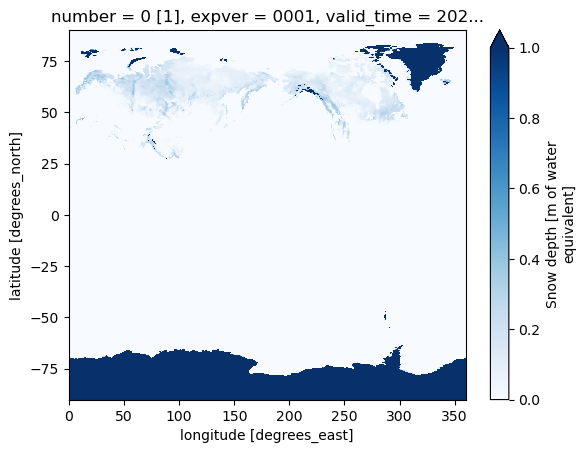

In [31]:
era5_sd_march.plot.imshow(vmin=0, vmax=1, cmap='Blues')